In [1]:
import os
from glob import glob

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.init as init

from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

import numpy as np
from PIL import Image

# Hyperparameter

In [2]:
seed = 1

IMG_HEIGHT = 128
IMG_WIDTH = 128

lr = 0.001
beta = 3

gamma = 10

epochs = 30
log_interval = 2

no_cuda = False

use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print('Num_GPU :', torch.cuda.device_count())
batch_size = 64 * torch.cuda.device_count()
test_batch_size = 64 * torch.cuda.device_count()

torch.manual_seed(seed)

kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

Num_GPU : 2


# Model

In [3]:
class GradReverse(torch.autograd.Function):
    """
    Extension of grad reverse layer
    """
    @staticmethod
    def forward(ctx, x, constant):
        ctx.constant = constant
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        grad_output = grad_output.neg() * ctx.constant
        return grad_output, None

    def grad_reverse(x, constant):
        return GradReverse.apply(x, constant)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #f1
        self.conv1 = nn.Conv2d(3, 64, 5, 2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(inplace=True)

        self.conv2 = nn.Conv2d(3, 64, 5, 2, 2)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.LeakyReLU(inplace=True)
       
        #f2
        self.conv3 = nn.Conv2d(128, 128, 5, 2, 2)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.LeakyReLU(inplace=True)

        self.conv4 = nn.Conv2d(128, 128, 5, 2, 2)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.LeakyReLU(inplace=True)
       
        #f3
        self.conv5 = nn.Conv2d(256, 128, 5, 2, 2)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.LeakyReLU(inplace=True)

        self.conv6 = nn.Conv2d(256, 128, 5, 2, 2)
        self.bn6 = nn.BatchNorm2d(128)
        self.relu6 = nn.LeakyReLU(inplace=True)
       
        #f4
        self.conv7 = nn.Conv2d(256, 256, 5, 2, 2)
        self.bn7 = nn.BatchNorm2d(256)
        self.relu7 = nn.LeakyReLU(inplace=True)

        self.conv8 = nn.Conv2d(256, 256, 5, 2, 2)
        self.bn8 = nn.BatchNorm2d(256)
        self.relu8 = nn.LeakyReLU(inplace=True)
       
        #encode
        self.fc1 = nn.Linear(int(IMG_HEIGHT/16)*int(IMG_WIDTH/16)*512, 256)
        self.fc2 = nn.Linear(256,int(IMG_HEIGHT/16)*int(IMG_WIDTH/16)*256)
        
        #d1
        self.conv9 = nn.ConvTranspose2d(256, 128, 5, 2, 2, 1)
        self.bn9 = nn.BatchNorm2d(128)
        self.relu9 = nn.LeakyReLU(inplace=True)
        
        #d1_uni
        self.conv10 = nn.ConvTranspose2d(256, 256, 5, 1, 2)
        self.bn10 = nn.BatchNorm2d(256)
        self.relu10 = nn.LeakyReLU(inplace=True)
        
        #d2
        self.conv11 = nn.ConvTranspose2d(256, 128, 5, 2, 2, 1)
        self.bn11 = nn.BatchNorm2d(128)
        self.relu11 = nn.LeakyReLU(inplace=True)       

        #d2_uni
        self.conv12 = nn.Conv2d(256, 256, 5, 1, 2)
        self.bn12 = nn.BatchNorm2d(256)
        self.relu12 = nn.LeakyReLU(inplace=True)  

        #d3
        self.conv13 = nn.ConvTranspose2d(256, 64, 5, 2, 2, 1)
        self.bn13 = nn.BatchNorm2d(64)
        self.relu13 = nn.LeakyReLU(inplace=True)          

        #d3_uni
        self.conv14 = nn.Conv2d(128, 128, 5, 1, 2)
        self.bn14 = nn.BatchNorm2d(128)
        self.relu14 = nn.LeakyReLU(inplace=True) 
        
        #decode
        self.conv15 = nn.ConvTranspose2d(128, 3, 5, 2, 2, 1)
        self.conv16 = nn.ConvTranspose2d(128, 1, 5, 2, 2, 1)
        
        #domain classifier
        self.fc3 = nn.Linear(int(IMG_HEIGHT/16)*int(IMG_WIDTH/16)*512, 100)
        self.relu15 = nn.LeakyReLU(inplace=True) 
        self.fc4 = nn.Linear(100, 1)
        
    def forward(self, x, constant=1):
        f1_1 = self.relu1(self.bn1(self.conv1(x))) #64x64x64
        f1_2 = self.relu2(self.bn2(self.conv2(x))) #64x64x64
        
        f1 = torch.cat((f1_1, f1_2), 1) #128x64x64
        
        f2_1 = self.relu3(self.bn3(self.conv3(f1))) #128x32x32
        f2_2 = self.relu4(self.bn4(self.conv4(f1))) #128x32x32

        f2 = torch.cat((f2_1, f2_2), 1) #256x32x32
        
        f3_1 = self.relu5(self.bn5(self.conv5(f2))) #128x16x16
        f3_2 = self.relu6(self.bn6(self.conv6(f2))) #128x16x16
        
        f3 = torch.cat((f3_1, f3_2), 1) #256x16x16

        f4_1 = self.relu7(self.bn7(self.conv7(f3))) #256x8x8
        f4_2 = self.relu8(self.bn8(self.conv8(f3))) #256x8x8
        
        f4 = torch.cat((f4_1, f4_2), 1) #512x8x8

        x = f4.view(f4.size(0), -1)
        encode = self.fc1(x) #256
        
        d1 = self.fc2(encode) #256x8x8
        d1 = self.relu9(self.bn9(self.conv9(d1.view(-1,256,int(IMG_HEIGHT/16),int(IMG_WIDTH/16))))) #128x16x16
             
        d1_uni = torch.cat((d1, f3_2), 1) #256x16x16
        d1_uni = self.relu10(self.bn10(self.conv10(d1_uni))) #256x16x16
        
        d2 = self.relu11(self.bn11(self.conv11(d1_uni))) #128x32x32
        
        d2_uni = torch.cat((d2, f2_2), 1) #256x32x32
        d2_uni = self.relu12(self.bn12(self.conv12(d2_uni))) #256x32x32
        
        d3 = self.relu13(self.bn13(self.conv13(d2_uni))) #64x64x64
        
        d3_uni = torch.cat((d3, f1_2), 1) #128x64x64
        d3_uni = self.relu14(self.bn14(self.conv14(d3_uni))) #128x64x64

        rec = self.conv15(d3_uni) #3x128x128
        mask = self.conv16(d3_uni) #1x128x128
        
        logits = GradReverse.grad_reverse(x, constant)
        logits = self.relu15(self.fc3(logits))
        logits = self.fc4(logits)
               
        return torch.sigmoid(rec), torch.sigmoid(mask), torch.sigmoid(logits)

# Preprocess

In [5]:
train_paths = glob('C:/Users/IVCL/Desktop/duck/no_circle/train/image/*.png')
test_paths = glob('C:/Users/IVCL/Desktop/duck/real/test/image/*.png')
val_paths = glob('C:/Users/IVCL/Desktop/duck/real/val/image/*.png')
len(train_paths), len(test_paths), len(val_paths)

(20000, 253, 1000)

In [6]:
def get_label(path):
    rec_path = path[:-20]+'rec/'+path[-14:]
    rec = Image.open(rec_path).convert("RGB")
    rec = np.array(rec)
    #label = np.where(label>0,1.0,0)
    rec = torch.from_numpy(rec/255)
    rec = rec.permute(2,0,1)
    
    mask_path = path[:-20]+'label/'+path[-14:]
    mask = Image.open(mask_path)
    mask = np.array(mask)
    mask = np.where(mask>0,1.0,0)
    mask = torch.from_numpy(mask)
    mask = mask.unsqueeze_(0)
    #step1
    
    domain = torch.ones([1])
    if path[27:31] == 'real':
        domain = torch.zeros([1])         
    
    return rec.float(), mask.float(), domain.float()

In [7]:
class Dataset(Dataset):
    def __init__(self, data_paths, transform=None):

        self.data_paths = data_paths
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        path = self.data_paths[idx]
        # Read Image
        image = Image.open(path).convert("RGB")
        
        #Get Label
        rec, mask, domain = get_label(path)
        
        if self.transform:
            image = self.transform(image)

        return image, rec, mask, domain

In [8]:
train_loader = torch.utils.data.DataLoader(
    Dataset(train_paths, 
            transforms.Compose([
                #transforms.RandomHorizontalFlip(), 
                transforms.ToTensor(), 
                transforms.Normalize(
                    mean=[0.406, 0.406, 0.406], 
                    std=[0.225, 0.225, 0.225])])
           ),
    batch_size=batch_size, 
    shuffle=True, 
    **kwargs
)

val_loader = torch.utils.data.DataLoader(
    Dataset(val_paths,
           transforms.Compose([
               transforms.ToTensor(), 
               transforms.Normalize(
                   mean=[0.406, 0.406, 0.406], 
                   std=[0.225, 0.225, 0.225])])
           ),
    batch_size=test_batch_size, 
    shuffle=False, 
    **kwargs
)

test_loader = torch.utils.data.DataLoader(
    Dataset(test_paths,
           transforms.Compose([
               transforms.ToTensor(), 
               transforms.Normalize(
                   mean=[0.406, 0.406, 0.406], 
                   std=[0.225, 0.225, 0.225])])
           ),
    batch_size=test_batch_size, 
    shuffle=False, 
    **kwargs
)

In [9]:
for i, (data, rec, mask, domain) in enumerate(test_loader):
    if i == 0:
        print(data[0].shape, rec[0].shape, mask[0].shape, domain[0].shape)
        break

torch.Size([3, 128, 128]) torch.Size([3, 128, 128]) torch.Size([1, 128, 128]) torch.Size([1])


# Optimization

In [10]:
model = Net()
model = nn.DataParallel(model)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

# Visualization

In [11]:
def visualization(model, test_path, rec_path, mask_path):
    model.eval()
    model.to(device)
    transform = transforms.Compose([
                   transforms.ToTensor(), 
                   transforms.Normalize(
                       mean=[0.406, 0.406, 0.406], 
                       std=[0.225, 0.225, 0.225])])

    image = Image.open(test_path).convert("RGB")
    image = transform(image).unsqueeze_(0)
    rec_result, mask_result, domain_result = model(image)
    domain_result = domain_result.to('cpu').detach().numpy()
    rec_result, mask_result = rec_result.permute(0,2,3,1).to('cpu').detach().numpy(), mask_result.to('cpu').detach().numpy()
    mask_result = np.where(mask_result[0,:,:,:]>=0.5, 1.0, 0)
    
    test_image = plt.imread(test_path)
    rec_image = plt.imread(rec_path)
    mask_image = plt.imread(mask_path)
    plt.figure(figsize=(20,20))
    display_list = [test_image, rec_image, rec_result[0,:,:,:], mask_image, mask_result[0,:,:]]
    title = ['Input Image', 'Ground Truth(Rec)', 'Predicted(Rec)','Ground Truth(Mask)', 'Predicted(Mask)']
    
    print('Predicted domain :', domain_result[0,0])
    
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

Predicted domain : 0.5092747


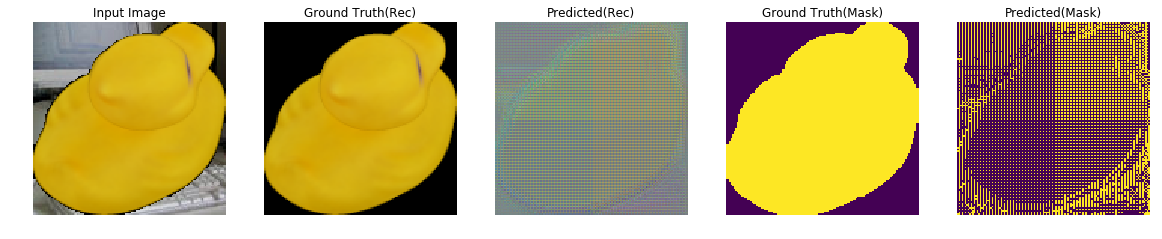

In [12]:
test_path = 'C:/Users/IVCL/Desktop/duck/no_circle/train/image/duck_00001.png'
rec_path = 'C:/Users/IVCL/Desktop/duck/no_circle/train/rec/duck_00001.png'
mask_path = 'C:/Users/IVCL/Desktop/duck/no_circle/train/label/duck_00001.png'
visualization(model, test_path, rec_path, mask_path)

# Training

In [13]:
checkpoint_path = './checkpoints_tc120_no_circle_reconstruction2_beta3_stride_GRL'

In [14]:
loss_list = []
val_loss_list = []
rec_loss_list = []
val_rec_loss_list = []
mask_loss_list = []
val_mask_loss_list = []
domain_loss_list = []

for epoch in range(1, epochs + 1):
    # Train Mode
    model.to(device).train()

    train_loss_sum = 0
    val_loss_sum = 0 
    train_rec_loss_sum = 0
    val_rec_loss_sum = 0 
    train_mask_loss_sum = 0
    val_mask_loss_sum = 0
    train_domain_loss_sum = 0
    val_domain_loss_sum = 0
    
    cut_num = 10 # 1 epoch당 train할 batch_idx (256 * 10 = 2560)
    
    #steps
    start_steps = epoch * len(train_loader.dataset)
    total_steps = epochs * len(train_loader.dataset)
        
    for batch_idx, (sdata, tdata) in enumerate(zip(train_loader, val_loader)):
        
        #setup hyperparameters
        p = float(batch_idx + start_steps) / total_steps
        constant = 2. / (1. + np.exp(-gamma * p)) - 1
        lr = 0.01 / (1. + 10 * p) ** 0.75
        
        #prepare the data
        data, rec_target, mask_target, domain_target = sdata
        data, rec_target, mask_target, domain_target = data.to(device), rec_target.to(device), mask_target.to(device), domain_target.to(device)
        
        data2, rec_target2, mask_target2, domain_target2 = tdata
        data2, rec_target2, mask_target2, domain_target2 = data2.to(device), rec_target2.to(device), mask_target2.to(device), domain_target2.to(device)
        
        #setup optimizer
        optimizer.lr = lr
        optimizer.zero_grad()
        
        #predict and compute the loss
        rec_output, mask_output, domain_output = model(data, constant)
        rec_output2, mask_output2, domain_output2 = model(data2, constant)
        
        mask_target_reverse = torch.ones(1,IMG_HEIGHT,IMG_WIDTH).to(device) - mask_target
        
        multiply = torch.mul(rec_output, mask_target)
        multiply2 = torch.mul(rec_output, mask_target_reverse)
        
        rec_target2 = torch.mul(rec_target, mask_target_reverse)
        
        rec_loss1 = F.mse_loss(multiply, rec_target)
        rec_loss2 = F.mse_loss(multiply2, rec_target2)
        mask_loss = F.binary_cross_entropy(mask_output, mask_target)
        
        rec_loss = rec_loss1*beta + rec_loss2
        
        domain_loss1 = F.binary_cross_entropy(domain_output, domain_target)
        domain_loss2 = F.binary_cross_entropy(domain_output2, domain_target2)
        domain_loss = domain_loss1 + domain_loss2
        
        loss = rec_loss + mask_loss - domain_loss
        
        loss.backward()
        optimizer.step()
        
        train_loss_sum = train_loss_sum + loss.item()
        train_rec_loss_sum = train_rec_loss_sum + rec_loss.item()
        train_mask_loss_sum = train_mask_loss_sum + mask_loss.item()
        train_domain_loss_sum = train_domain_loss_sum + domain_loss.item()
                
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tRec_Loss: {: 6f}\tMask_Loss: {: 6f}\tDomain_Loss: {: 6f}'.format(
                epoch, batch_idx * len(data), cut_num * batch_size,
                100. * batch_idx * len(data) / (cut_num * batch_size), train_loss_sum / ((batch_idx + 1e-7) * len(data)),
                train_rec_loss_sum / ((batch_idx + 1e-7) * len(data)),
                train_mask_loss_sum / ((batch_idx + 1e-7) * len(data)),
                train_domain_loss_sum / ((batch_idx + 1e-7) * len(data))))
            
        if batch_idx == cut_num:
            break
    
    # Test mode
    model.eval()
    val_loss = 0
    val_rec_loss = 0
    val_mask_loss = 0
    
    with torch.no_grad():
        for data, rec_target, mask_target, domain_target in val_loader:
            data, rec_target, mask_target, domain_target = data.to(device), rec_target.to(device), mask_target.to(device), domain_target.to(device)
            rec_output, mask_output, domain_output = model(data)
            
            mask_target_reverse = torch.ones(1,IMG_HEIGHT,IMG_WIDTH).to(device) - mask_target
            
            multiply = torch.mul(rec_output, mask_target)
            multiply2 = torch.mul(rec_output, mask_target_reverse)
            
            rec_target2 = torch.mul(rec_target, mask_target_reverse)
            
            rec_loss1 = F.mse_loss(multiply, rec_target)
            rec_loss2 = F.mse_loss(multiply2, rec_target2)
            
            val_rec_loss = rec_loss1*beta + rec_loss2
            val_mask_loss = F.binary_cross_entropy(mask_output, mask_target)
            
            val_loss = val_rec_loss + val_mask_loss
            
            val_loss_sum = val_loss_sum + val_loss.item()
            val_rec_loss_sum = val_rec_loss_sum + val_rec_loss.item()
            val_mask_loss_sum = val_mask_loss_sum + val_mask_loss.item()
            
    loss_list.append(train_loss_sum / len(train_loader.dataset))
    val_loss_list.append(val_loss_sum / len(val_loader.dataset))
    rec_loss_list.append(train_rec_loss_sum / len(train_loader.dataset))
    val_rec_loss_list.append(val_rec_loss_sum / len(val_loader.dataset)) 
    mask_loss_list.append(train_mask_loss_sum / len(train_loader.dataset))
    val_mask_loss_list.append(val_mask_loss_sum / len(val_loader.dataset)) 
    domain_loss_list.append(train_domain_loss_sum / len(val_loader.dataset))
    
    print('\nValidation set: Average Loss: {:.6f}\tRec_Loss: {: 6f}\tMask_Loss: {: 6f}'.format(
        val_loss_sum / len(val_loader.dataset), val_rec_loss_sum / len(val_loader.dataset),
        val_mask_loss_sum / len(val_loader.dataset)))
    
    if epoch % 2 == 0:
        torch.save(model.state_dict(), checkpoint_path+'/epoch-%s.pt'%epoch)

C:\Users\IVCL\Miniconda3\envs\tc120\lib\site-packages\torch\cuda\nccl.py:24: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Train Epoch: 1 [0/1280 (0%)]	Loss: 3726.696596	Rec_Loss:  35233.336966	Mask_Loss:  79643.372446	Domain_Loss:  111150.015146
Train Epoch: 1 [256/1280 (20%)]	Loss: -0.073534	Rec_Loss:  0.004301	Mask_Loss:  0.006050	Domain_Loss:  0.083885
Train Epoch: 1 [512/1280 (40%)]	Loss: -0.156338	Rec_Loss:  0.002791	Mask_Loss:  0.003552	Domain_Loss:  0.162682
Train Epoch: 1 [768/1280 (60%)]	Loss: -0.156377	Rec_Loss:  0.002102	Mask_Loss:  0.002702	Domain_Loss:  0.161180

Validation set: Average Loss: 0.005661	Rec_Loss:  0.000819	Mask_Loss:  0.004843
Train Epoch: 2 [0/1280 (0%)]	Loss: -1216719.001532	Rec_Loss:  4438.068136	Mask_Loss:  9510.779055	Domain_Loss:  1230667.829514
Train Epoch: 2 [256/1280 (20%)]	Loss: -0.158494	Rec_Loss:  0.000580	Mask_Loss:  0.001328	Domain_Loss:  0.160402
Train Epoch: 2 [512/1280 (40%)]	Loss: -0.130821	Rec_Loss:  0.000444	Mask_Loss:  0.001058	Domain_Loss:  0.132322
Train Epoch: 2 [768/1280 (60%)]	Loss: -0.116955	Rec_Loss:  0.000387	Mask_Loss:  0.000944	Domain_Loss:  0.118

# Loss Curve

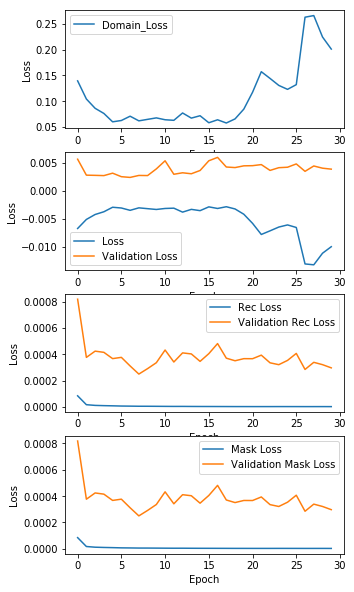

In [22]:
plt.figure(figsize=(5,10))

plt.subplot(4,1,1)
plt.plot(domain_loss_list, label='Domain_Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(4,1,2)
plt.plot(loss_list, label='Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(4,1,3)
plt.plot(rec_loss_list, label='Rec Loss')
plt.plot(val_rec_loss_list, label='Validation Rec Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(4,1,4)
plt.plot(rec_loss_list, label='Mask Loss')
plt.plot(val_rec_loss_list, label='Validation Mask Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Restore Checkpoint

In [23]:
weight_dict = torch.load(checkpoint_path+'/epoch-6.pt')

In [24]:
model.load_state_dict(weight_dict)

<All keys matched successfully>

Predicted domain : 0.99172133


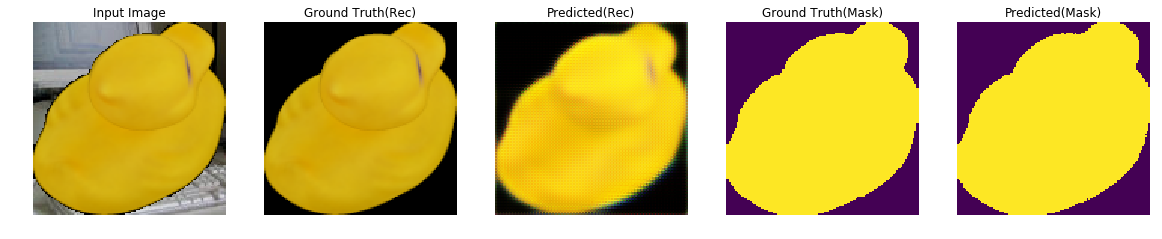

In [25]:
test_path = 'C:/Users/IVCL/Desktop/duck/no_circle/train/image/duck_00001.png'
rec_path = 'C:/Users/IVCL/Desktop/duck/no_circle/train/rec/duck_00001.png'
mask_path = 'C:/Users/IVCL/Desktop/duck/no_circle/train/label/duck_00001.png'

visualization(model, test_path, rec_path, mask_path)

In [ ]:
i = 0
for path in test_paths:
    rec_path = path[:-20]+'rec/'+path[-14:]
    mask_path = path[:-20]+'label/'+path[-14:]
    i = i+1
    print('num_image :',i)
    visualization(model, path, rec_path, mask_path)

In [26]:
def precision(truth, pred):
    epsilon = 1e-7
    pred = pred.to('cpu').detach().numpy()
    truth = truth.to('cpu').detach().numpy()
    
    pred = np.where(pred >= 0.5, 1.0, 0)
    
    true_positive = np.sum(pred * truth)
    true_positive_false_positive = np.sum(pred)
    
    precision = true_positive / (true_positive_false_positive + epsilon)
                                 
    return precision

                                 
def recall(truth, pred):
    epsilon = 1e-7
    pred = pred.to('cpu').detach().numpy()
    truth = truth.to('cpu').detach().numpy()
    
    pred = np.where(pred >= 0.5, 1.0, 0)
    
    true_positive = np.sum(pred * truth)
    true_positive_false_negative =np.sum(truth)
    
    recall = true_positive / (true_positive_false_negative + epsilon)
                                 
    return recall

In [27]:
test_prec = 0
test_rec = 0
num_test = 0
for batch_idx, (data, rec_target, mask_target, domain_target) in enumerate(test_loader):
    data, rec_target, mask_target, domain_target = data.to(device), rec_target.to(device), mask_target.to(device), domain_target.to(device)
    rec_output, mask_output, domain_output = model(data)
    test_prec += precision(mask_target, mask_output)
    test_rec += recall(mask_target, mask_output)
    num_test += 1
    
print('test_precision :',100. * test_prec / num_test, '\ttest_recall :', 100. * test_rec / num_test)

test_precision : 95.47736296735032 	test_recall : 90.29612689398017
